##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Universal Sentence Encoder


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Funiversal-sentence-encoder%2F4%20OR%20google%2Funiversal-sentence-encoder-large%2F5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


## Setup

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [1]:
# %%capture
# !pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [2]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

2021-12-07 10:11:45.285794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 10:11:45.285811: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-07 10:12:38.820122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 10:12:38.820341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 10:12:38.820394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns



In [2]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.0345856249332428, -0.01799013838171959, 0.001980567816644907, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833392217755318, -0.08185011148452759, 0.06890937685966492, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.026461733505129814, -0.01911567710340023, -0.042070381343364716, ...]



In [3]:
np.inner(message_embeddings, message_embeddings)

array([[ 1.        , -0.03712355,  0.02429866],
       [-0.03712355,  1.0000001 ,  0.22339317],
       [ 0.02429866,  0.22339317,  1.        ]], dtype=float32)

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [12]:
def plot_similarity(labels, features, rotation, print_labels=True):
  corr = np.inner(features, features)
  labels = [m[:25] + '/' + str(len(m)) for m in labels]
  sns.set(rc = {'figure.figsize':(20,12)})
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      annot=print_labels, fmt='.1f',
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [13]:
messages = [
# length 250
"What is a color or a friend.",
"This house has a big room and some small rooms.",
"My father was a rolling stone.",
"My father is a good guy.",
"When I get older.",
"When I was younger."
]

run_and_plot(messages)

NameError: name 'embed' is not defined

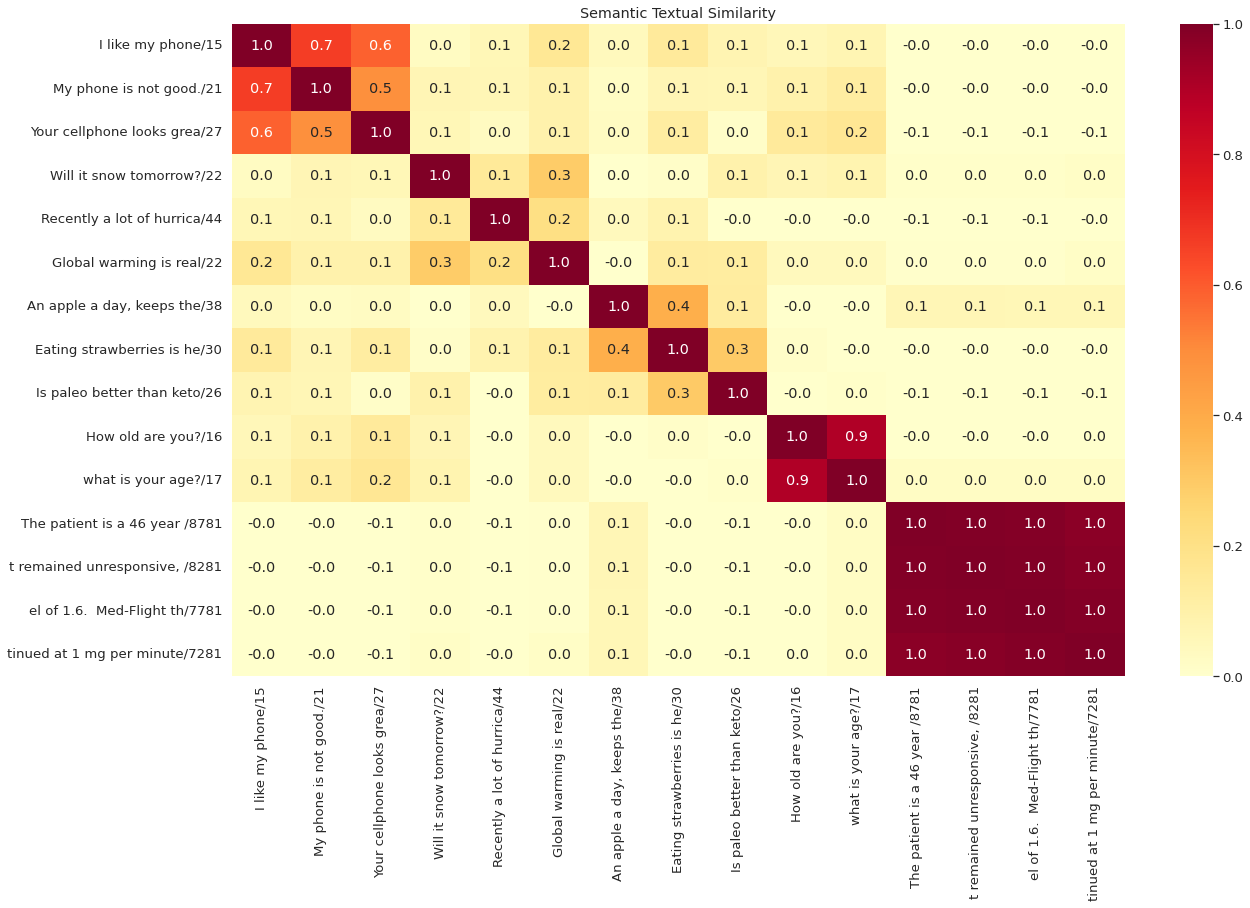

In [6]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",

    # mimic styled notes
    "The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"t remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"el of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"tinued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",

]

run_and_plot(messages)
               

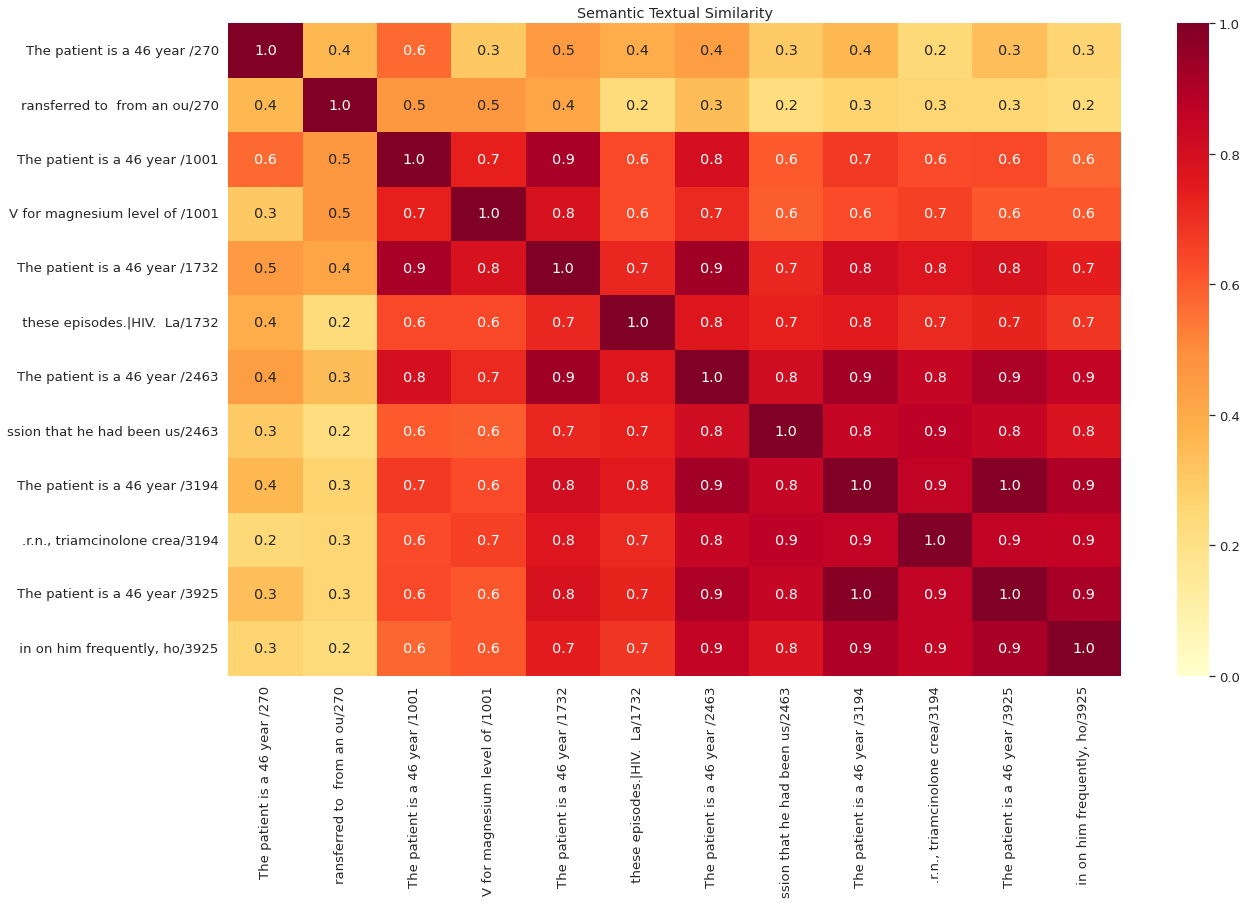

In [7]:
messages = [
# length 250
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from ",
"ransferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unrespons",



# length 981
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium leve",
"V for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated b",



# length 1712
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV",
" these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three da",



# length 2443
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had be",
"ssion that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crac",



# length 3174
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone",
".r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8",



# length 3905
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequentl",
" in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine",
]

run_and_plot(messages)
               

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intrinsic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

### Download data

In [8]:
# import pandas
# import scipy
# import math
# import csv

# sts_dataset = tf.keras.utils.get_file(
#     fname="Stsbenchmark.tar.gz",
#     origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
#     extract=True)
# sts_dev = pandas.read_table(
#     os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
#     error_bad_lines=False,
#     skip_blank_lines=True,
#     usecols=[4, 5, 6],
#     names=["sim", "sent_1", "sent_2"])
# sts_test = pandas.read_table(
#     os.path.join(
#         os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
#     error_bad_lines=False,
#     quoting=csv.QUOTE_NONE,
#     skip_blank_lines=True,
#     usecols=[4, 5, 6],
#     names=["sim", "sent_1", "sent_2"])
# # cleanup some NaN values in sts_dev
# sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

### Evaluate Sentence Embeddings

In [9]:
# sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

# def run_sts_benchmark(batch):
#   sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
#   sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
#   cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
#   clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
#   scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
#   """Returns the similarity scores"""
#   return scores

# dev_scores = sts_data['sim'].tolist()
# scores = []
# for batch in np.array_split(sts_data, 10):
#   scores.extend(run_sts_benchmark(batch))

# pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
# print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
#     pearson_correlation[0], pearson_correlation[1]))

In [10]:
# !pip3 install transformers

In [11]:
from transformers import AutoTokenizer, AutoModel

#checkpoint = "allenai/longformer-base-4096"
#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
#checkpoint = "dmis-lab/biobert-large-cased-v1.1"
#checkpoint = "mrm8488/longformer-base-4096-finetuned-squadv2"
#checkpoint = "johngiorgi/declutr-small"
checkpoint = "johngiorgi/declutr-base"
#checkpoint = "johngiorgi/declutr-sci-base"
#checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at johngiorgi/declutr-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
text = "my father was a Rolling Stone"*100
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

In [13]:
outputs = model(**inputs)

In [14]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [15]:
outputs['last_hidden_state'][:,7,:].shape #, outputs['pooler_output'].shape, 

torch.Size([1, 768])

In [16]:
#outputs['last_hidden_state'][:,-1,:] == outputs.pooler_output

In [17]:
import torch

def embed_trsf(messages):
    inputs = tokenizer(messages, padding=True, truncation=True, return_tensors="pt")
    #print(inputs)
    with torch.no_grad():
        outputs = model(**inputs)
    try:
        embed_trsf = outputs.pooler_output
        return torch.nn.functional.normalize(embed_trsf.detach()).numpy()
    except:
        embed_trsf = outputs.last_hidden_state # pooler_output
        return torch.nn.functional.normalize(embed_trsf[:, 0, :].detach()).numpy()

def run_and_plot_trsf(messages_):
  message_embeddings_ = embed_trsf(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [18]:
m = ["The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  hepatitis C and cirrhosis.  Patient was transferred to  from ",
            "transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unrespons"]

inputs = tokenizer(m, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

outputs.pooler_output

tensor([[ 0.0087, -0.1195, -0.1423,  ...,  0.0281, -0.0592,  0.1464],
        [-0.1026, -0.0900, -0.1597,  ..., -0.1116, -0.0451,  0.1509]])

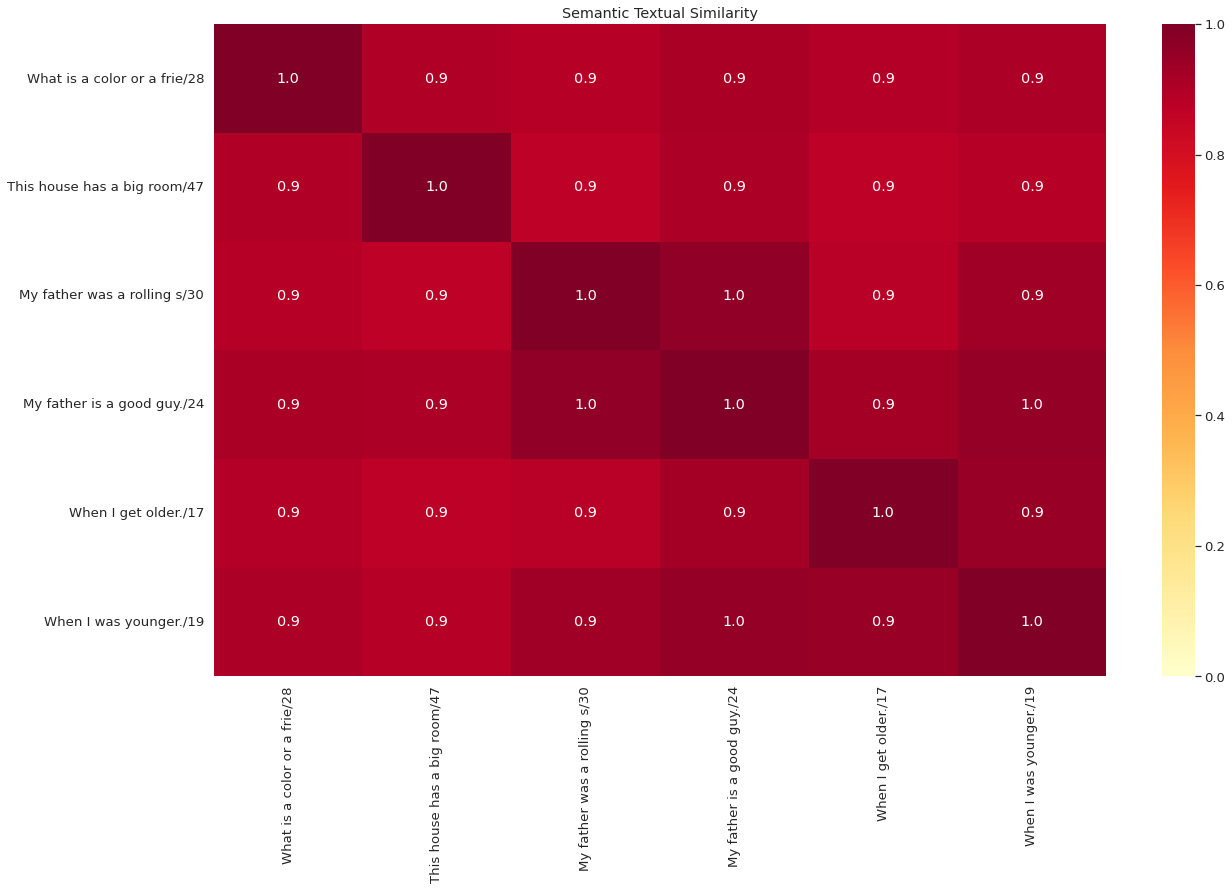

In [19]:
messages = [
"What is a color or a friend.",
"This house has a big room and some small rooms.",
"My father was a rolling stone.",
"My father is a good guy.",
"When I get older.",
"When I was younger."
]

run_and_plot_trsf(messages)

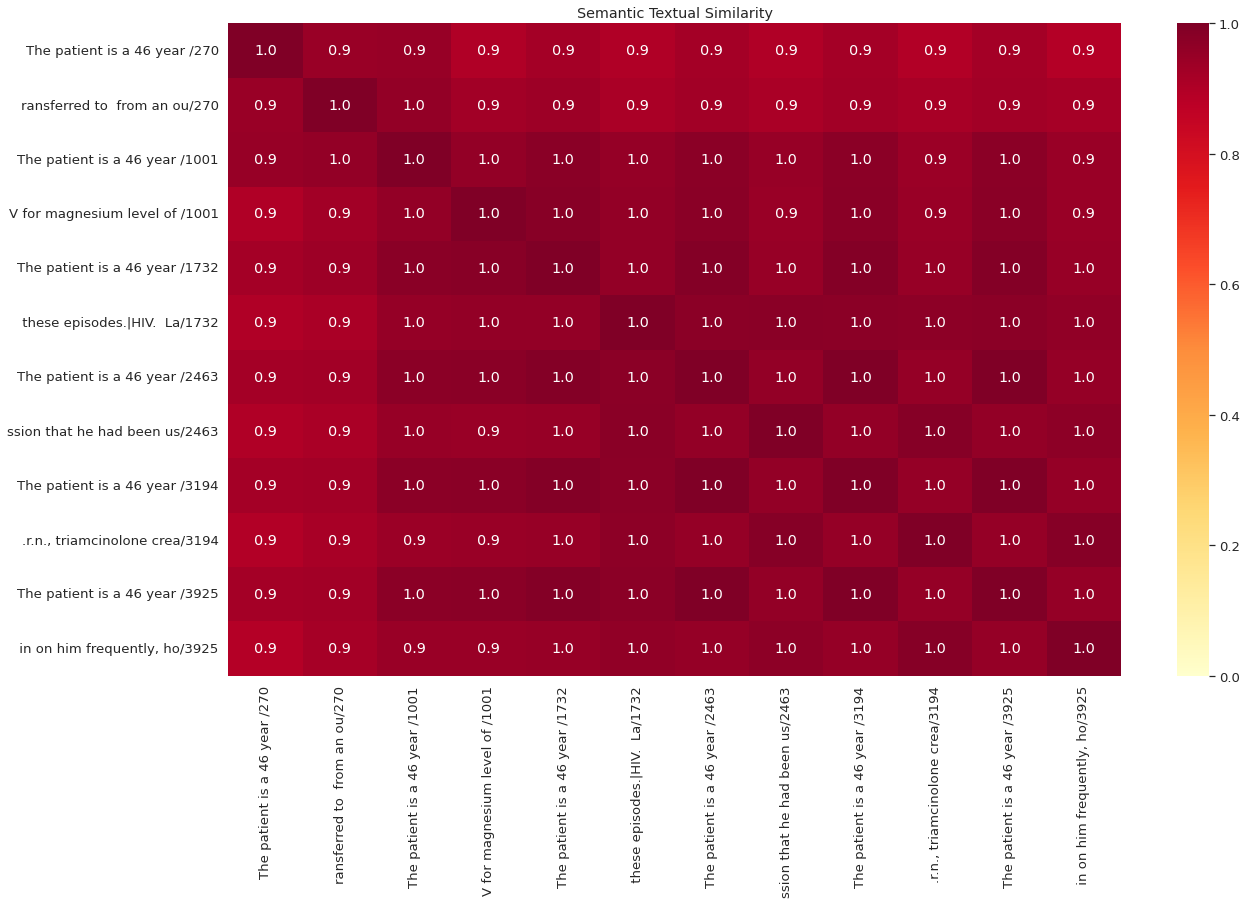

In [20]:
messages = [
# length 250
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from ",
"ransferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unrespons",



# length 981
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium leve",
"V for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated b",



# length 1712
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV",
" these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three da",



# length 2443
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had be",
"ssion that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crac",



# length 3174
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone",
".r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8",



# length 3905
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequentl",
" in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine",
]

run_and_plot_trsf(messages)
               

In [21]:
message_embeddings = torch.nn.functional.normalize(embed_trsf(messages[:8]))
np.inner(message_embeddings, message_embeddings)

AttributeError: 'numpy.ndarray' object has no attribute 'norm'

In [ ]:
message_embeddings[0])

In [ ]:
model

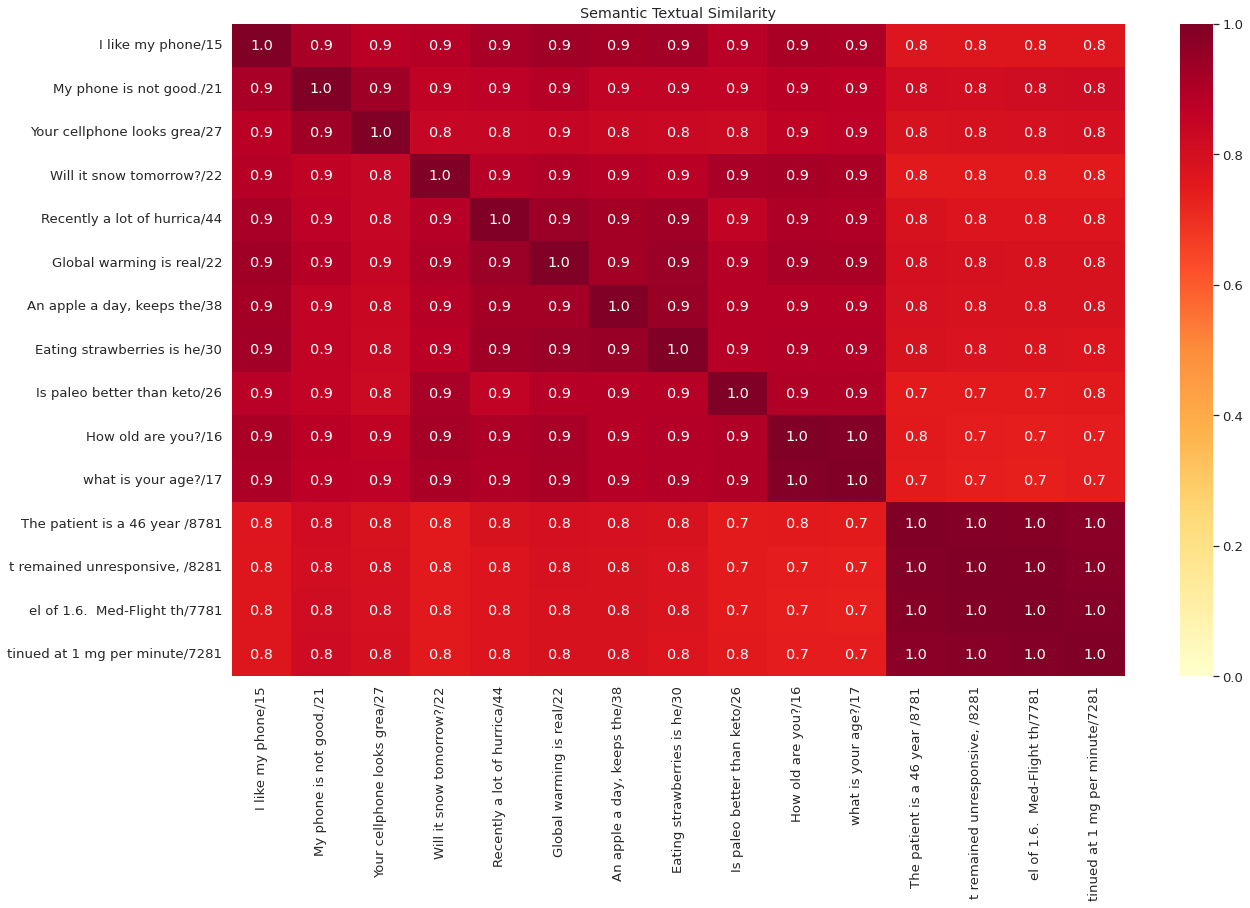

In [22]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",

    # mimic styled notes
    "The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"t remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"el of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"tinued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",

]

run_and_plot_trsf(messages)
               

In [1]:
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-mpnet-base-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
sentence_embeddings = model.encode(sentences)

#Print the embeddings
#for sentence, embedding in zip(sentences, sentence_embeddings):
#    print("Sentence:", sentence)
#    print("Embedding:", embedding)
#    print("")

In [14]:
def run_and_plot_se(messages_, print_labels=True):
    message_embeddings_ = model.encode(messages_)
    plot_similarity(messages_, message_embeddings_, 90, print_labels)

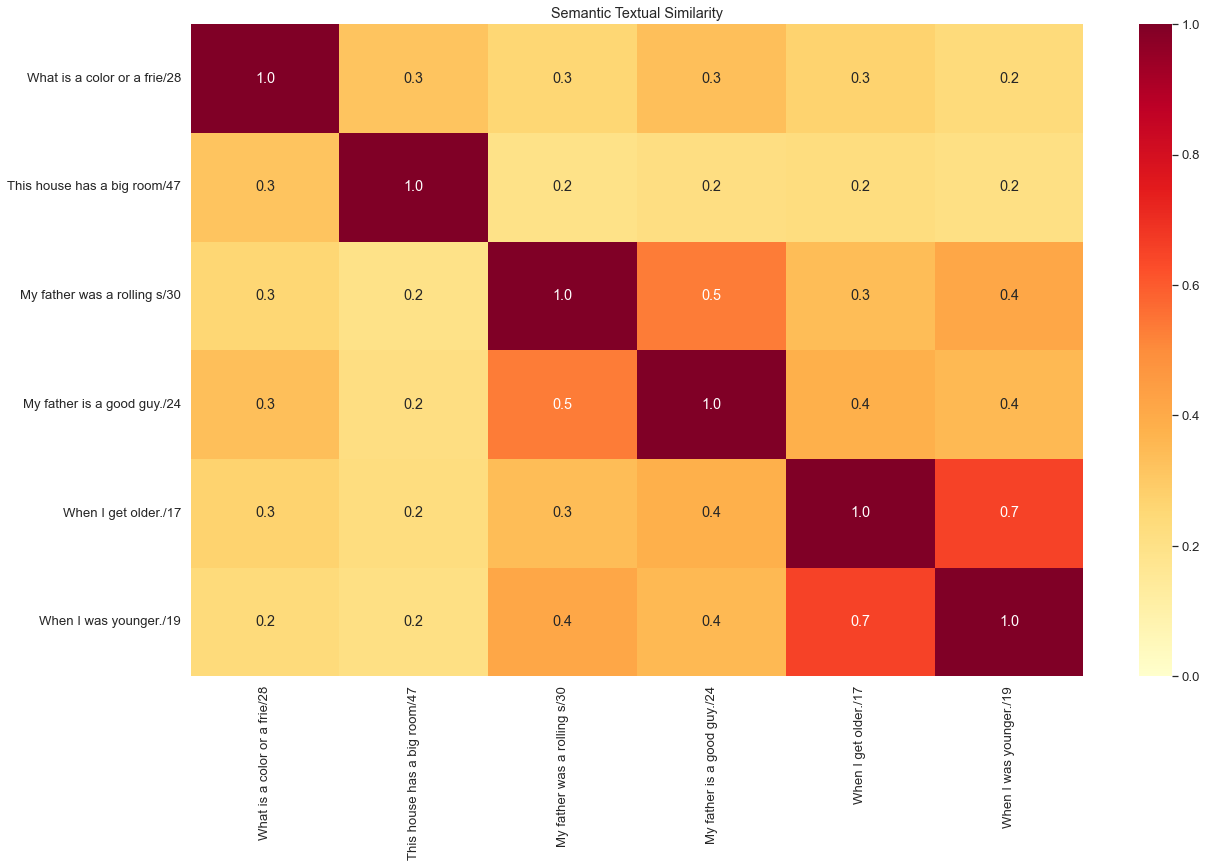

In [17]:
messages = [
"What is a color or a friend.",
"This house has a big room and some small rooms.",
"My father was a rolling stone.",
"My father is a good guy.",
"When I get older.",
"When I was younger."
]

run_and_plot_se(messages)

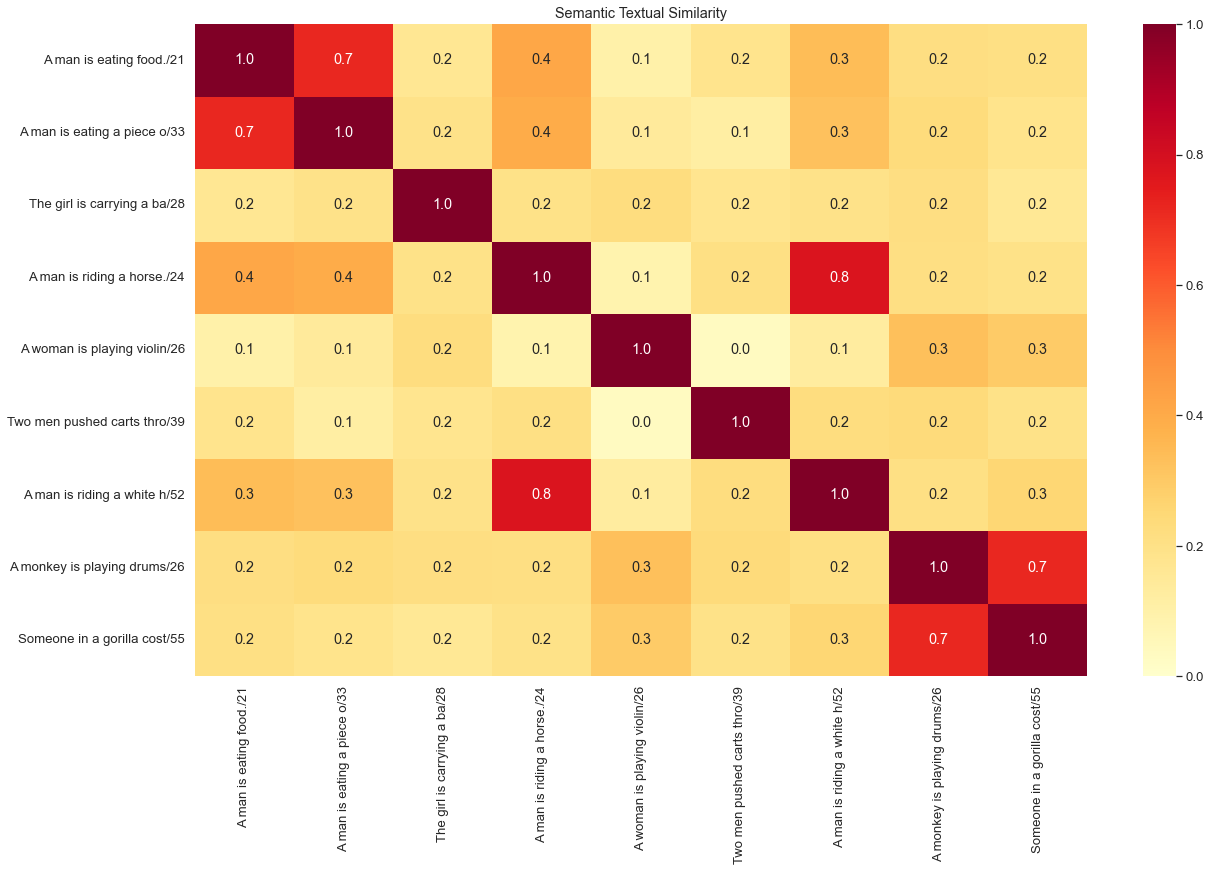

In [18]:
messages = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]
run_and_plot_se(messages)

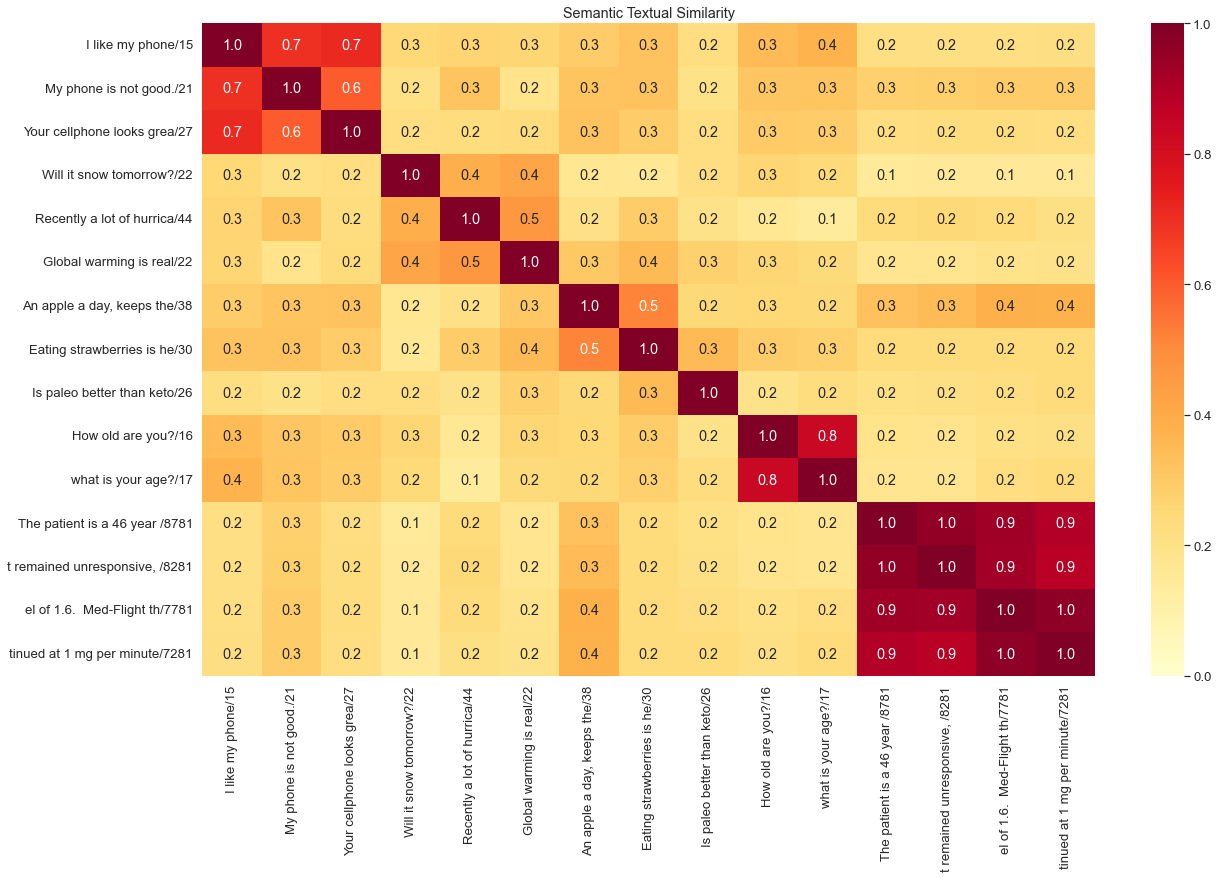

In [19]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",

    # mimic styled notes
    "The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"t remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"el of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",
"tinued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine drip from admission until 5:00 a.m. on the morning of .  At this time patient began to experience visual hallucinations and became slightly agitated.  Therefore, the lidocaine drip was decreased from 3 mg per minute to 1 mg per minute.  However, as patient's agitation continued even with the decreased dose of lidocaine, the lidocaine drip was stopped at 7:00 a.m.  Patient was switched to mexiletine 100 mg p.o. b.i.d. as this is also a class Ib antiarrhythmic. Patient tolerated this medication much better and his neurological status cleared.  He no longer had visual hallucinations and he tolerated the mexiletine dose quite well.  Patient was also started on labetalol 100 mg b.i.d. This beta blocker was chosen as patient's urine tox was positive for cocaine.  He also tolerated this medication well.  Patient had no repeat episodes of ventricular tachycardia or ventricular fibrillation during his hospital course.|  17:18 T:    12:39 JOB#:  ",

]

run_and_plot_se(messages)

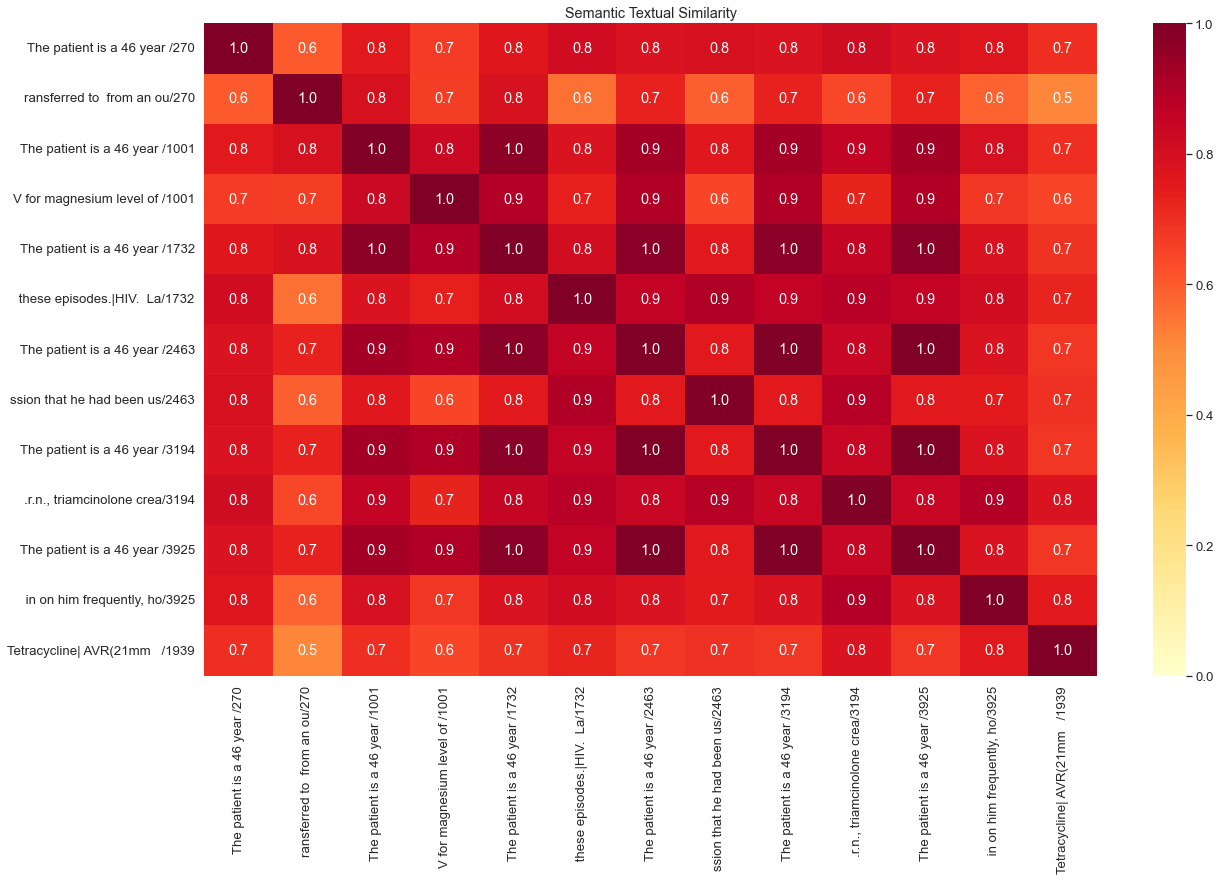

In [20]:
messages = [
# length 250
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from ",
"ransferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unrespons",



# length 981
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium leve",
"V for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated b",



# length 1712
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV",
" these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three da",



# length 2443
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had be",
"ssion that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crac",



# length 3174
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone",
".r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8",


# length 3905
"The patient is a 46 year old gentleman with past medical history including end stage HIV, placement on   Hospital.  Patient also has past medical history significant for polysubstance abuse including cocaine, hepatitis C and cirrhosis.  Patient was transferred to  from an outside hospital for recurrent v-fib arrest in the setting of having an ICD placed one week prior to admission.  Patient was found down on the morning of admission by a neighbor. unresponsive, called EMS.  When EMS came, patient remained unresponsive, but his vital signs were stable.  He had a paced rhythm.  He had normal blood pressure and normal oxygen saturation.  Patient was then transferred to an outside hospital in .  While there his ICD discharged at least two times for episodes of ventricular tachycardia. Rhythm strips from the outside hospital were not available at the time of admission.  Per report patient was given amiodarone 150 mg IV three times and he was given magnesium sulfate 4 gm IV for magnesium level of 1.6.  Med-Flight then transferred patient to  as CCU beds were not available elsewhere.  En route to the hospital patient experienced another two episodes of v-fib and his ICD discharged each time, converting patient back into paced rhythm.  During the shocks patient was reported to be alert.  He denied chest pain, shortness of breath, had stable blood pressure and stable oxygen saturation.  On arrival to the CCU patient experienced two shocks from his ICD for torsades.  Amiodarone was continued at 1 mg per minute.  Patient went into v-fib arrest two times just after his admission.  Again the ICD converted him back into a stable paced rhythm.  Again his sats and blood pressure remained stable with these episodes.|HIV.  Last CD4 count 438, last viral load less than 50 copies per ml from his outpatient infectious disease physician's notes in his medical record. These levels were from .  HIV course is complicated by nonischemic cardiomyopathy and also complicated by candidal esophagitis.  Hepatitis C and cirrhosis presumed secondary to IV drug abuse.  Hep A positive as well.  Nonischemic cardiomyopathy with EF of 20%. Patient had cardiac cath in  that was negative for coronary artery disease.  Patient is also status post ICD placement on   Hospital. Patient is status post DDD pacer placed four years ago for complete heart block.  Polysubstance abuse including crack cocaine, heroin and alcohol.  Patient stated on admission that he had been using crack cocaine for the week prior to admission.  Most recent use was three days prior to admission.  Chronic renal insufficiency.  Uncertain of baseline creatinine.  Old hospital records from   indicate that the renal failure was secondary to diuretic over-use.  Peripheral neuropathy.  B-12 deficiency and macrocytic anemia.  Stasis dermatitis and eosinophilic folliculitis.  Asthma.|Abacavir 300 mg b.i.d., saquinavir 400 mg b.i.d., Combivir tabs one b.i.d., Norvir|00 mg b.i.d., Protonix 40 q.day, trazodone 100 q.h.s., lisinopril 10 b.i.d., Lasix 80 b.i.d., methadone 250 mg q.d., Lexapro 10 mg q.d., digoxin 125 mcg q.d., Bactrim one double strength q.d., Zyrtec 10 q.d., sublingual nitroglycerin p.r.n., triamcinolone cream, albuterol inhaler p.r.n.|The patient denied any recent illness. He states that since the ICD had been placed, he has felt fatigued, but denies chest pain, shortness of breath.  He does admit to recent crack cocaine use, most recently three days prior to admission.|The patient states that he was clean and sober for three years until this past week.  He states that the stress of his illness and his mother's illness, who is bed bound status post CVA, had prompted this use.  Patient lives alone and states that he has been very depressed at home and felt that his family avoids him because of his HIV status and feels that he cannot take care of himself appropriately.  His sister and his niece do look in on him frequentl",
" in on him frequently, however.  Per report of his sister and his niece, his house is disordered and they comment that patient is barely functional.  Patient has a history of smoking, alcohol abuse and cocaine use as stated previously.|Vital signs on admission included temperature of 98.2, pulse 66, blood pressure 104 to 130 over|4 to 65, respiratory rate 14, sat 100% on 10 liters nasal cannula, weight 74 kg. In general, patient was alert and oriented times two, alert to person and place, but not time. He denied any distress.  He appeared disheveled, but otherwise did not appear in any discomfort.  HEENT pupils equal, round and reactive to light and accommodation. Oropharynx clear without lesions.  Heart regular rate and rhythm, S1, S2, prominent S3,  to  holosystolic murmur at the left upper and left lower sternal borders, does not radiate to carotids, does not radiate to axillae.  PMI laterally displaced.  Right ventricular heave.  JVP markedly elevated at 14 cm.  Lungs bibasilar crackles, left greater than right.  Abdominal exam soft, nondistended, nontender, hepatomegaly 3 cm beneath the costal margin.  Extremities no cyanosis, clubbing or edema with good distal pulses.  Neuro cranial nerves II-XII intact.  Strength grossly normal. Sensation grossly normal.|From the outside hospital data included magnesium of 1.6.  Tox screen included serum, ethanol, salicylates, acetaminophen and tricyclic levels which were all negative.  Digoxin level was normal at 0.85, normal being|.9 to 2.0.  CK 226, MB 3.3, troponin I 0.1.  Hematocrit|0.8, white count 5.4, platelets 155.  Chem-7 132, 4.0, 92,|6, 16, 1.5, 138.  Calcium 8.2.  Chest x-ray from the outside hospital showed cardiomegaly with clear lung fields.  Head CT at the outside hospital, performed because patient had an unwitnessed fall, was read at the outside hospital as possible evolving left parietal infarct with no evidence of bleed.  However, this head CT was read by our radiologists as no evidence of stroke or hemorrhage.  EKG showed wide complex rhythm of left bundle morphology, rate 100 with paced beat preceded by a P and followed by a nonpaced ventricular beat, QTc 433.  Strips from Med-Flight consistent with polymorphic VT of torsade type.  Echo one week prior to admission from outside hospital showed moderate MR  , left ventricular hypokinesis, EF 20%.  Lab data from admission to  hematocrit 32.8, white count 4.7, platelets 159.  Chemistry sodium 133, potassium 4.8, chloride 96, bicarb 26, BUN 20, creatinine 1.2, glucose 148.  Calcium 8.6, mag 2.6, phos 4.9, albumin 3.6.  Serum tox was negative for benzo, negative for barbiturates.  Urine tox was performed that was positive for cocaine and positive for methadone.  UA was negative for UTI.|1.  Cardiology. Rhythm.  For patient's recurrent torsades he was initially continued on an amio drip at 1 mg per minute.  As the QT was prolonged, patient was switched from amio to a lidocaine drip as lidocaine decreases the QT interval while amio increases the QT interval.  Patient's pacer was interrogated on the night of admission and reprogrammed.  On interrogation it was revealed that patient had 16 episodes of v-fib with heart rate between 200 to 230 beats per minute, requiring 17 joules and then 31 joules to convert patient back into a paced rhythm.  His pacer was a DDD that was originally set for 50 to 120 beats per minute with paced AV at 180 msec.  The mode was changed by the EP Fellow to DDD at|0 to 120 beats per minute with the thinking that increasing the rate of pacing would shorten the QT interval and hopefully prevent recurrent torsade.  The pacer was also changed so that the VF zone first shock to patient at 31 joules rather than 17 joules as patient was requiring 31 joules of energy to convert him back to a paced rhythm. Patient's magnesium was checked frequently and magnesium after repletion was stable at 2.6.  The patient was kept on a lidocaine",

"Tetracycline| AVR(21mm   porcine), CABGx2(SVG>PDA,LIMA>LAD)|PMH: HTN, sleep apnea on CPAP, DM2, ^lipids, Diverticulitis, AS, poor balance w/frequent falls, L4 & L5 fractures, subdural hematoma PSH: ccy, appendectomy, partial colectomy, knee arthroscopy x3, pilonidal cyst excision|father deceased from MI at age 41|Admission HR 82 RR 16 BP 129/69 NAD Lungs CTAB Heart RRR,  HSM Abdomen soft, NT, obese Extrem 2+ edema| 03:25AM BLOOD WBC-7.9 RBC-3.28*# Hgb-9.6*# Hct-28.4* MCV-86 MCH-29.1 MCHC-33.7 RDW-18.7* Plt Ct-295  08:59PM BLOOD Hct-28.7*  03:03PM BLOOD Hct-24.7*  06:37AM BLOOD Hct-22.2*  03:25AM BLOOD PT-13.4 PTT-27.1 INR(PT)-1.1  03:25AM BLOOD Glucose-170* UreaN-24* Creat-0.5 Na-138 K-3.8 Cl-104 HCCOMPLETE BLOOD COUNT WBC RBC Hgb Hct MCV MCH MCHC RDW Plt Ct  10:37AM          29.0* O3-32 AnGap-6*|25 AM CHEST (PORTABLE AP) Reason: ?ptx  MEDICAL CONDITION:|5 year old woman with s/;p cabg REASON FOR THIS EXAMINATION: ?ptx INDICATION: 75-year-old woman with status post CABG; evaluate for pneumothorax. COMPARISON: . SINGLE AP UPRIGHT RADIOGRAPH OF THE CHEST AT 7:40 A.M.: There are moderate bilateral pleural effusions, slightly worse than prior study. There are associated bibasilar opacities which are also worse and may reflect worsening atelectasis and/or pneumonia. Left PICC is terminating at the upper SVC. There is no pulmonary edema or pneumothorax. IMPRESSION: No pneumothorax. Worsening moderate bilateral pleural effusions and bibasilar consolidation.|38 PM CT ABDOMEN W/O CONTRAST; CT PELVIS W/O CONTRAST Reason: r/o retroperitoneal bleed with drop in hct  MEDICAL CONDITION:|5 year old woman with s/p cabg REASON FOR THIS EXAMINATION: r/o retroperitoneal bleed with drop in hct CONTRAINDICATIONS for IV CONTRAST: None. HISTORY: 75-year-old female after cardiac surgery with falling hematocrit and concern for retroperitoneal hematoma. The patient has known right groin hematoma after removal of a femoral catheter."
]

run_and_plot_se(messages)

In [2]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [67]:
from sentence_transformers import SentenceTransformer, models
import torch.nn as nn
#word_embedding_model = models.Transformer('bert-base-uncased')
word_embedding_model = models.Transformer('jamesmullenbach/CLIP_DNote_BERT_Context')

tokens = ["[DOC]", "[QRY]"]
word_embedding_model.tokenizer.add_tokens(tokens, special_tokens=True)
word_embedding_model.auto_model.resize_token_embeddings(len(word_embedding_model.tokenizer))

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=1024, activation_function=nn.Tanh())
normalizer = models.Normalize()
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model, normalizer])

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
sentence_embeddings = model.encode(sentences)

Some weights of the model checkpoint at jamesmullenbach/CLIP_DNote_BERT_Context were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:
sentence_embeddings.shape

(3, 1024)

In [92]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [8]:
import pickle

df = pickle.load(open('/Users/jplasser/Documents/AI Master/WS2021/MastersThesis/code.nosync/CNEP/src/data/mimic3/full_train_data_unique.pickle', 'rb'))

In [9]:
notes = df['notes']
messages = []
no_messages = 50

for i in range(no_messages):
    messages.append(f'"{notes[i][:200]}",')
    
run_and_plot_se(messages, print_labels=False)

NameError: name 'run_and_plot_se' is not defined

In [3]:
# experimental
model = SentenceTransformer('all-mpnet-base-v2')
word_embedding_model = model._modules['0']
pooling_model = model._modules['1']
normalize_model = model._modules['2']

#pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=1024, activation_function=nn.Tanh())
#normalizer = models.Normalize()
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model, normalizer])

NameError: name 'models' is not defined

In [11]:
model = SentenceTransformer('../models/pretrained_sentence_transformer')

In [12]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 1024, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [112]:
model._modules['3']

Normalize()

In [129]:
pretrained_model="abc"

In [130]:
pretrained_model

False

In [25]:
# for m in word_embedding_model.modules():
#     print(m)

In [14]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 1024, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [140]:
model.save('pretrained_sentence_transformer')

# SentenceTransformer Model used in Master Thesis Code

In [ ]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

# 'microsoft/mpnet-base'
word_embedding_model = models.Transformer('sentence-transformers/all-mpnet-base-v2', max_seq_length=384)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=1024,
                           activation_function=nn.Tanh())

normalize_model = models.Normalize()
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model, normalize_model])

# freeze transformer layers of the model
auto_model = model._first_module().auto_model
for param in auto_model.parameters():
    param.requires_grad = False
    

In [23]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

# clinical BERT model embeddings
word_embedding_model = models.Transformer('emilyalsentzer/Bio_ClinicalBERT', max_seq_length=384)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=15000,
                           activation_function=nn.ReLU())
dense_model2 = models.Dense(in_features=15000, out_features=1024,
                           activation_function=nn.ReLU())

normalize_model = models.Normalize()

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model, dense_model2, normalize_model])

# freeze transformer layers of the model
auto_model = model._first_module().auto_model
for param in auto_model.parameters():
    param.requires_grad = False
    


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 15000, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
  (3): Dense({'in_features': 15000, 'out_features': 1024, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
  (4): Normalize()
)

In [25]:
model.save('pretrained_sentence_transformer_clinicalBertEmbeds')

In [4]:
model.load('pretrained_sentence_transformer_3')

AttributeError: 'SentenceTransformer' object has no attribute 'load'

In [2]:
model = SentenceTransformer('pretrained_sentence_transformer')

In [3]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 1024, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [27]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Sentence embeddings:
tensor([[ 0.0225, -0.0783, -0.0230,  ..., -0.0083,  0.0265, -0.0020],
        [ 0.0417,  0.0011, -0.0155,  ..., -0.0218, -0.0636, -0.0088]])


In [28]:
sentence_embeddings.shape

torch.Size([2, 768])

In [30]:
np.inner(sentence_embeddings, sentence_embeddings)

array([[0.9999999 , 0.40488434],
       [0.40488434, 1.        ]], dtype=float32)

In [31]:
sentence_embeddings @ sentence_embeddings.T

tensor([[1.0000, 0.4049],
        [0.4049, 1.0000]])

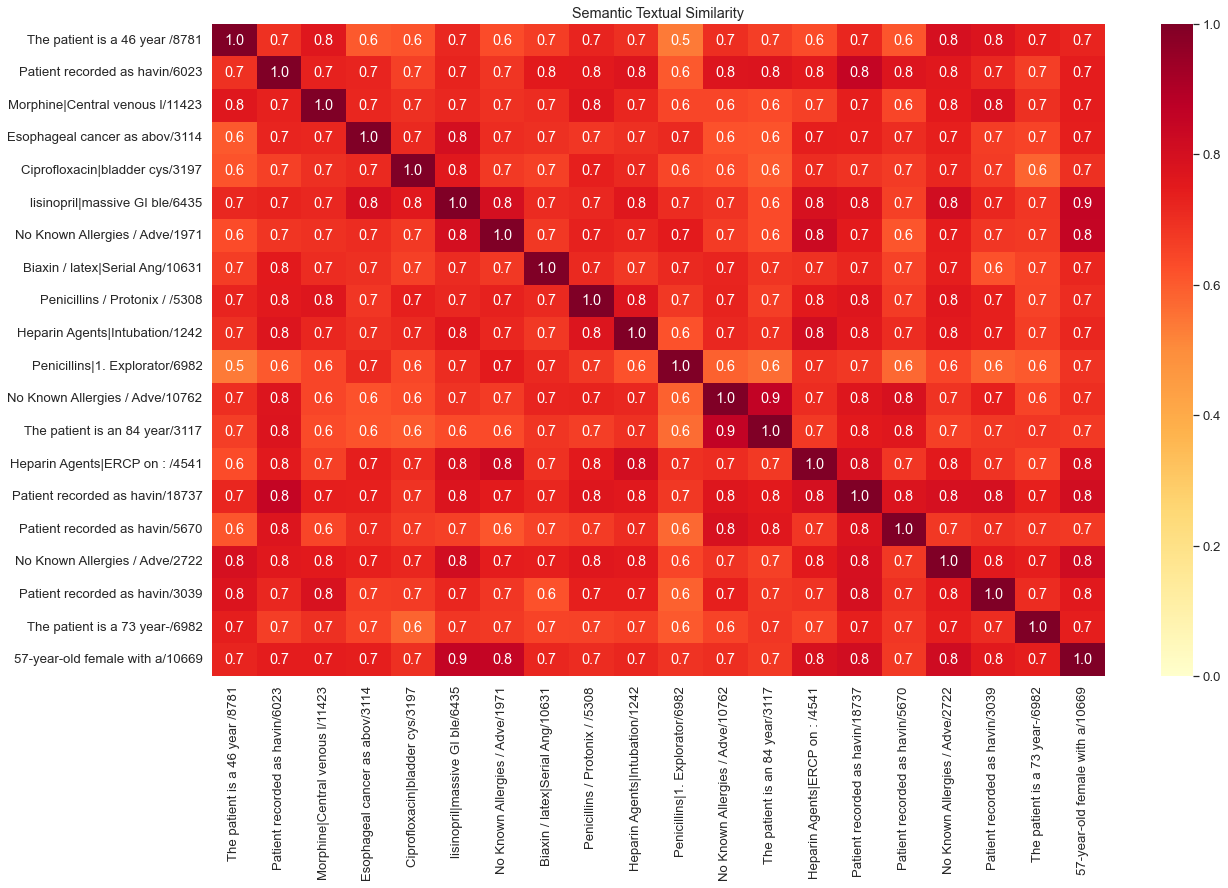

In [23]:
messages = df['notes'][:-1:len(df['notes'])//20]
run_and_plot_se(messages)